In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import liriscat
liriscat.utils.set_seed(0)
from liriscat.dataset import preprocessing_utilities as pu

import logging
import gc
import json
import torch
import pandas as pd
import argparse
import warnings
import time  # ← Ajouté pour mesurer le temps

In [2]:
liriscat.utils.setuplogger(verbose=True, log_name="CAT_test", debug=False)

In [3]:
dataset_name = "math2"
cdm="impact"
i_fold=4

In [4]:
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

config = liriscat.utils.generate_eval_config(
    CDM=cdm,
    dataset_name=dataset_name,
    i_fold = i_fold,
    load_params=True,
    save_params=False,
    esc = 'error',
    learning_rate = 0.001,
    batch_size = 512,
    valid_batch_size = 10000,
    num_epochs=100,
    eval_freq = 1,
    patience = 20,
    device = device,
    pred_metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b"],
    profile_metrics = ['meta_doa','pc-er','rm'],
    meta_trainer='GAP',
    valid_metric= 'rmse',
    n_query=16,
    num_inner_users_epochs=3,
    lambda_=2.6180638633142202e-05,
    inner_user_lr=0.0030952659036283066,
    meta_lr=0.01
)
config['learning_users_emb_lr'] = 0.001
logging.info(f'#### config : {config} ####')

concept_map = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'
))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'
))

nb_modalities = torch.load(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',
    weights_only=True
)

train_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
valid_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
test_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)

train_data = liriscat.dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
valid_data = liriscat.dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
test_data  = liriscat.dataset.EvalDataset(test_df,  concept_map, metadata, config, nb_modalities)

S = liriscat.selectionStrategy.Random(train_data.metadata, **config)
S.init_models(train_data, valid_data)

# — Mesure du temps d'entraînement
logging.info("⏳ Début de l'entraînement...")
t_start = time.time()
S.train(train_data, valid_data)
t_end = time.time()
logging.info(f"✅ Entraînement terminé en {t_end - t_start:.2f} secondes.")

[INFO 43:38] Using device: cuda
[INFO 43:38] #### config : {'seed': 0, 'dataset_name': 'math2', 'load_params': True, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'rmse', 'learning_rate': 0.001, 'batch_size': 512, 'valid_batch_size': 10000, 'num_epochs': 100, 'eval_freq': 1, 'patience': 20, 'device': device(type='cuda'), 'lambda': 2.6180638633142202e-05, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc', 'rmse', 'mae', 'mi_prec', 'mi_rec', 'mi_f_b', 'mi_auc', 'ma_prec', 'ma_rec', 'ma_f_b'], 'profile_metrics': ['meta_doa', 'pc-er', 'rm'], 'num_responses': 12, 'low_mem': False, 'n_query': 16, 'CDM': 'impact', 'i_fold': 4, 'num_inner_users_epochs': 3, 'num_inner_epochs': 10, 'inner_lr': 0.0001, 'inner_user_lr': 0.0030952659036283066, 'meta_lr': 0.01, 'meta_trainer': 'GAP', 'num_workers': 0, 'pin_memory': False, 'debug': False, 'learn

/lustre/fsn1/projects/rech/enh/unv34ei/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/100 [00:00<?, ?it/s]

[INFO 46:15] - meta_params: 0.01
[INFO 46:15] - cross_cond: 0.01
[INFO 46:15] - meta_lambda: 0.01
[INFO 46:15] - learning_users_emb: 0.001
[INFO 46:49] rmse : 0.5371128916740417
[INFO 46:49] valid_rmse : 0.6868451237678528
[INFO 46:49] valid_loss : 0.9418724775314331


  1%|          | 1/100 [02:15<3:42:52, 135.08s/it]

[INFO 48:34] - meta_params: 0.01
[INFO 48:34] - cross_cond: 0.01
[INFO 48:34] - meta_lambda: 0.01
[INFO 48:34] - learning_users_emb: 0.001
[INFO 49:14] rmse : 0.5410871505737305
[INFO 49:14] valid_rmse : 0.6919273138046265
[INFO 49:14] valid_loss : 0.9443886280059814


  2%|▏         | 2/100 [04:39<3:49:37, 140.58s/it]

[INFO 51:05] - meta_params: 0.01
[INFO 51:05] - cross_cond: 0.01
[INFO 51:05] - meta_lambda: 0.01
[INFO 51:05] - learning_users_emb: 0.001
[INFO 51:45] rmse : 0.5348818898200989
[INFO 51:45] valid_rmse : 0.6839921474456787
[INFO 51:45] valid_loss : 0.9433355331420898


  3%|▎         | 3/100 [07:11<3:55:26, 145.64s/it]

[INFO 53:38] - meta_params: 0.01
[INFO 53:38] - cross_cond: 0.01
[INFO 53:38] - meta_lambda: 0.01
[INFO 53:38] - learning_users_emb: 0.001
[INFO 54:19] rmse : 0.5355335474014282
[INFO 54:19] valid_rmse : 0.6848254799842834
[INFO 54:19] valid_loss : 0.9398385286331177


  4%|▍         | 4/100 [09:44<3:57:56, 148.71s/it]

[INFO 56:11] - meta_params: 0.01
[INFO 56:11] - cross_cond: 0.01
[INFO 56:11] - meta_lambda: 0.01
[INFO 56:11] - learning_users_emb: 0.001
[INFO 56:52] rmse : 0.5432926416397095
[INFO 56:52] valid_rmse : 0.6947476267814636
[INFO 56:52] valid_loss : 0.9424330592155457


  5%|▌         | 5/100 [12:17<3:57:42, 150.13s/it]

[INFO 58:43] - meta_params: 0.01
[INFO 58:43] - cross_cond: 0.01
[INFO 58:43] - meta_lambda: 0.01
[INFO 58:43] - learning_users_emb: 0.001
[INFO 59:24] rmse : 0.5405343174934387
[INFO 59:24] valid_rmse : 0.6912203431129456
[INFO 59:24] valid_loss : 0.9417358636856079


  6%|▌         | 6/100 [14:49<3:56:23, 150.89s/it]

[INFO 01:16] - meta_params: 0.01
[INFO 01:16] - cross_cond: 0.01
[INFO 01:16] - meta_lambda: 0.01
[INFO 01:16] - learning_users_emb: 0.001
[INFO 01:56] rmse : 0.5415473580360413
[INFO 01:56] valid_rmse : 0.6925157904624939
[INFO 01:56] valid_loss : 0.941450834274292


  7%|▋         | 7/100 [17:22<3:54:39, 151.40s/it]

[INFO 03:52] - meta_params: 0.005
[INFO 03:52] - cross_cond: 0.005
[INFO 03:52] - meta_lambda: 0.005
[INFO 03:52] - learning_users_emb: 0.0005
[INFO 04:33] rmse : 0.5396117568016052
[INFO 04:33] valid_rmse : 0.6900405883789062
[INFO 04:33] valid_loss : 0.9426546692848206


  8%|▊         | 8/100 [19:58<3:54:46, 153.12s/it]

[INFO 06:27] - meta_params: 0.005
[INFO 06:27] - cross_cond: 0.005
[INFO 06:27] - meta_lambda: 0.005
[INFO 06:27] - learning_users_emb: 0.0005
[INFO 07:08] rmse : 0.5435677170753479
[INFO 07:09] valid_rmse : 0.6950993537902832
[INFO 07:09] valid_loss : 0.9423338770866394


  9%|▉         | 9/100 [22:34<3:53:17, 153.81s/it]

[INFO 09:00] - meta_params: 0.005
[INFO 09:00] - cross_cond: 0.005
[INFO 09:00] - meta_lambda: 0.005
[INFO 09:00] - learning_users_emb: 0.0005
[INFO 09:39] rmse : 0.537483811378479
[INFO 09:39] valid_rmse : 0.6873194575309753
[INFO 09:39] valid_loss : 0.9416413903236389


 10%|█         | 10/100 [25:05<3:49:24, 152.93s/it]

[INFO 11:29] - meta_params: 0.0025
[INFO 11:29] - cross_cond: 0.0025
[INFO 11:29] - meta_lambda: 0.0025
[INFO 11:29] - learning_users_emb: 0.00025
[INFO 12:09] rmse : 0.5459457635879517
[INFO 12:09] valid_rmse : 0.6981403231620789
[INFO 12:09] valid_loss : 0.9425634145736694


 11%|█         | 11/100 [27:34<3:45:11, 151.82s/it]

[INFO 13:58] - meta_params: 0.0025
[INFO 13:58] - cross_cond: 0.0025
[INFO 13:58] - meta_lambda: 0.0025
[INFO 13:58] - learning_users_emb: 0.00025
[INFO 14:35] rmse : 0.5415473580360413
[INFO 14:35] valid_rmse : 0.6925157904624939
[INFO 14:35] valid_loss : 0.9415622353553772


 12%|█▏        | 12/100 [30:01<3:40:19, 150.22s/it]

[INFO 16:22] - meta_params: 0.0025
[INFO 16:22] - cross_cond: 0.0025
[INFO 16:22] - meta_lambda: 0.0025
[INFO 16:22] - learning_users_emb: 0.00025
[INFO 17:00] rmse : 0.5498561263084412
[INFO 17:00] valid_rmse : 0.7031407952308655
[INFO 17:00] valid_loss : 0.9418630003929138


 13%|█▎        | 13/100 [32:25<3:35:24, 148.56s/it]

[INFO 18:47] - meta_params: 0.00125
[INFO 18:47] - cross_cond: 0.00125
[INFO 18:47] - meta_lambda: 0.00125
[INFO 18:47] - learning_users_emb: 0.000125
[INFO 19:24] rmse : 0.537483811378479
[INFO 19:24] valid_rmse : 0.6873194575309753
[INFO 19:24] valid_loss : 0.9427799582481384


 14%|█▍        | 14/100 [34:49<3:31:01, 147.23s/it]

[INFO 21:11] - meta_params: 0.00125
[INFO 21:11] - cross_cond: 0.00125
[INFO 21:11] - meta_lambda: 0.00125
[INFO 21:11] - learning_users_emb: 0.000125
[INFO 21:49] rmse : 0.5397964119911194
[INFO 21:49] valid_rmse : 0.6902767419815063
[INFO 21:49] valid_loss : 0.942010760307312


 15%|█▌        | 15/100 [37:14<3:27:39, 146.58s/it]

[INFO 23:36] - meta_params: 0.00125
[INFO 23:36] - cross_cond: 0.00125
[INFO 23:36] - meta_lambda: 0.00125
[INFO 23:36] - learning_users_emb: 0.000125
[INFO 24:14] rmse : 0.5401654839515686
[INFO 24:14] valid_rmse : 0.6907486915588379
[INFO 24:14] valid_loss : 0.9413747787475586


 16%|█▌        | 16/100 [39:39<3:24:23, 146.00s/it]

[INFO 26:02] - meta_params: 0.000625
[INFO 26:02] - cross_cond: 0.000625
[INFO 26:02] - meta_lambda: 0.000625
[INFO 26:02] - learning_users_emb: 6.25e-05
[INFO 26:39] rmse : 0.5409029126167297
[INFO 26:39] valid_rmse : 0.6916916966438293
[INFO 26:39] valid_loss : 0.9422027468681335


 17%|█▋        | 17/100 [42:05<3:21:42, 145.82s/it]

[INFO 28:27] - meta_params: 0.000625
[INFO 28:27] - cross_cond: 0.000625
[INFO 28:27] - meta_lambda: 0.000625
[INFO 28:27] - learning_users_emb: 6.25e-05
[INFO 29:05] rmse : 0.537483811378479
[INFO 29:05] valid_rmse : 0.6873194575309753
[INFO 29:05] valid_loss : 0.9406792521476746


 18%|█▊        | 18/100 [44:30<3:19:02, 145.64s/it]

[INFO 30:52] - meta_params: 0.000625
[INFO 30:52] - cross_cond: 0.000625
[INFO 30:52] - meta_lambda: 0.000625
[INFO 30:52] - learning_users_emb: 6.25e-05
[INFO 31:30] rmse : 0.5408108234405518
[INFO 31:30] valid_rmse : 0.6915739178657532
[INFO 31:30] valid_loss : 0.9412773847579956


 19%|█▉        | 19/100 [46:56<3:16:40, 145.68s/it]

[INFO 33:18] - meta_params: 0.0003125
[INFO 33:18] - cross_cond: 0.0003125
[INFO 33:18] - meta_lambda: 0.0003125
[INFO 33:18] - learning_users_emb: 3.125e-05
[INFO 33:56] rmse : 0.539980947971344
[INFO 33:56] valid_rmse : 0.6905127167701721
[INFO 33:56] valid_loss : 0.943041205406189


 20%|██        | 20/100 [49:21<3:14:08, 145.61s/it]

[INFO 35:43] - meta_params: 0.0003125
[INFO 35:43] - cross_cond: 0.0003125
[INFO 35:43] - meta_lambda: 0.0003125
[INFO 35:43] - learning_users_emb: 3.125e-05
[INFO 36:21] rmse : 0.5358126163482666
[INFO 36:21] valid_rmse : 0.6851823329925537
[INFO 36:21] valid_loss : 0.9423127770423889


 21%|██        | 21/100 [51:46<3:11:34, 145.50s/it]

[INFO 38:09] - meta_params: 0.0003125
[INFO 38:09] - cross_cond: 0.0003125
[INFO 38:09] - meta_lambda: 0.0003125
[INFO 38:09] - learning_users_emb: 3.125e-05
[INFO 38:47] rmse : 0.5326415300369263
[INFO 38:47] valid_rmse : 0.6811272501945496
[INFO 38:47] valid_loss : 0.943656325340271


 22%|██▏       | 22/100 [54:12<3:09:09, 145.51s/it]

[INFO 40:34] - meta_params: 0.00015625
[INFO 40:34] - cross_cond: 0.00015625
[INFO 40:34] - meta_lambda: 0.00015625
[INFO 40:34] - learning_users_emb: 1.5625e-05
[INFO 41:12] rmse : 0.5380397439002991
[INFO 41:12] valid_rmse : 0.6880303621292114
[INFO 41:12] valid_loss : 0.9403754472732544


 23%|██▎       | 23/100 [56:38<3:06:51, 145.61s/it]

[INFO 43:00] - meta_params: 0.00015625
[INFO 43:00] - cross_cond: 0.00015625
[INFO 43:00] - meta_lambda: 0.00015625
[INFO 43:00] - learning_users_emb: 1.5625e-05
[INFO 43:37] rmse : 0.5349750518798828
[INFO 43:37] valid_rmse : 0.6841112971305847
[INFO 43:37] valid_loss : 0.9405323266983032


 24%|██▍       | 24/100 [59:02<3:04:06, 145.35s/it]

[INFO 45:24] - meta_params: 0.00015625
[INFO 45:24] - cross_cond: 0.00015625
[INFO 45:24] - meta_lambda: 0.00015625
[INFO 45:24] - learning_users_emb: 1.5625e-05
[INFO 46:02] rmse : 0.5346023440361023
[INFO 46:03] valid_rmse : 0.6836346983909607
[INFO 46:03] valid_loss : 0.942063570022583


 24%|██▍       | 24/100 [1:01:28<3:14:39, 153.67s/it]

[INFO 46:03] -- END Training --
[INFO 46:03] ✅ Entraînement terminé en 3688.78 secondes.


In [8]:
def pareto_index(d):
    d_acc = d[0]
    d_meta = d[1]
    r = []
    for i in range(len(d_acc)):
        r.append(d_acc[i]['mi_acc'] * d_meta[i]['meta_doa'])
    return sum(r)

In [9]:
S.reset_rng()
d = S.evaluate_test(test_data, train_data, valid_data)
pi = pareto_index(d)
logging.info(f"Fold {config['i_fold']}; pareto_index: {pi}; results: {d}")

[INFO 49:02] train on cuda


100%|██████████| 16/16 [00:33<00:00,  2.11s/it]


[WARNING 49:40] Computing RM on meta and QUERY set
[INFO 49:43] RM: 0.36711719406966825
[WARNING 49:44] Computing RM on meta and QUERY set
[INFO 49:44] RM: 0.44283166046033995
[WARNING 49:46] Computing RM on meta and QUERY set
[INFO 49:46] RM: 0.49841144198967785
[WARNING 49:48] Computing RM on meta and QUERY set
[INFO 49:48] RM: 0.5424932596036567
[WARNING 49:49] Computing RM on meta and QUERY set
[INFO 49:49] RM: 0.5823001087561945
[WARNING 49:51] Computing RM on meta and QUERY set
[INFO 49:51] RM: 0.6169720453335703
[WARNING 49:52] Computing RM on meta and QUERY set
[INFO 49:52] RM: 0.6479468127733219
[WARNING 49:54] Computing RM on meta and QUERY set
[INFO 49:54] RM: 0.6755965718354072
[WARNING 49:56] Computing RM on meta and QUERY set
[INFO 49:56] RM: 0.7022598504986777
[WARNING 49:57] Computing RM on meta and QUERY set
[INFO 49:58] RM: 0.7285516960217054
[WARNING 49:59] Computing RM on meta and QUERY set
[INFO 49:59] RM: 0.7529042106098845
[WARNING 50:01] Computing RM on meta and

In [7]:
from torch import nn
from torch.utils import data
from tqdm import tqdm
from liriscat.dataset import UserCollate, QueryEnv
test_emb = evaluate_test_spec(S,test_data, train_data, valid_data).cpu()
train_emb = S.CDM.model.users_emb(torch.tensor(list(train_data.users_id), device=config['device'])).to('cpu')

[INFO 48:27] train on cuda


100%|██████████| 16/16 [00:34<00:00,  2.14s/it]


In [14]:
torch.save(test_emb,'../data/evolving_embs_math2.pt')
torch.save(train_emb,'../data/train_embs_math2.pt')

In [20]:
test_emb2 = torch.load('../data/evolving_embs_math2.pt')
train_emb2 = torch.load('../data/train_embs_math2.pt')

In [471]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

def ecdf_percentiles(X, d, value_per_dim):
    """
    For each dimension, computes the percentile of a given value within that dimension's distribution.
    X: np.ndarray of shape (n_users, n_dim)
    value_per_dim: array-like, shape (n_dim,), value[i] = value in dimension i
    Returns: percentiles, array of shape (n_dim,), between 0 and 1
    """
    percentiles = []
    n_users, n_dim = X.shape
    
    values = X[:, d]
    v = value_per_dim
    # Empirical CDF: proportion of values <= v
    return (((values <= v).sum() / len(values))*100).floor().int().item()

def plot_embedding_distribution(i, j, t_np, test_emb, bins=50, xlim=None, ylim=None, test_data=None):

    skills = {
    1: "Property of inequality",
    2: "Methods of data sampling",
    3: "Geometric progression",
    4: "Function versus equation",
    5: "Solving triangle",
    6: "Principles of data analysis",
    7: "Classical probability theory",
    8: "Linear programming",
    9: "Definitions of algorithm",
    10: "Algorithm logic",
    11: "Arithmetic progression",
    12: "Spatial imagination",
    13: "Abstract summarization",
    14: "Reasoning and demonstration",
    15: "Calculation",
    16: "Data handling"
    }
    
    x = t_np[:, i]
    y = t_np[:, j]

    # Main plot with marginal densities
    g = sns.jointplot(
        x=x, y=y,
        kind="kde",  # KDE for both joint and marginals
        fill=False,  # Contours only (no fill in joint)
        color="black",
        levels=8
    )

        # Set custom limits if provided
    if xlim is not None:
        g.ax_joint.set_xlim(xlim)
    if ylim is not None:
        g.ax_joint.set_ylim(ylim)

    test_users = torch.tensor(list(test_data.users_id))
    u_test = (-(test_emb[:,:,torch.tensor([i,j])][:,test_users,:]).std(axis=0).sum(dim=1)).argsort()
    users = test_users[u_test][:10]

    v=test_data.df[test_data.df['user_id'].isin(users.numpy())]
    w=v[test_data.df['dimension_id']==0]
    x = w.groupby('user_id')['correct'].mean()
    u = x.index[x.argmax()]

    g.ax_joint.scatter(test_emb[:,u,i],test_emb[:,u,j], s=15, color='tab:red')  

    # Grades : 
    g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
    g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)

    print(f"Student {u} : Category {i}: {g_i}/100, Category {j}: {g_j}/100")
    
    
    for idx in range(16):
        px = float(test_emb[idx, u, i])
        py = float(test_emb[idx, u, j])

        ylim = g.ax_joint.get_ylim()    
        xlim = g.ax_joint.get_xlim()

        perf_x=ecdf_percentiles(train_emb,i,px)
        perf_y=ecdf_percentiles(train_emb,j,py)

        # Vertical dotted line (to top marginal axis)
        g.ax_joint.axvline(x=px, ymin=(py-ylim[0])/(ylim[1]-ylim[0]), linestyle=':', color='black', alpha=0.5)
        g.ax_marg_x.axvline(px, linestyle=':', color='black', alpha=0.5)
        # Add user index label above
        g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]+1.0, str(idx+1), color='black', fontsize=7,
                         ha='center', va='top', rotation=0)

        if (idx//3)==idx/3:

            g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]-1, str(perf_x)+'%', color='black', fontsize=7,
                             ha='center', va='top', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))
            

        if idx==0:
            g.ax_marg_x.text( g.ax_marg_x.get_xlim()[1], g.ax_marg_x.get_ylim()[1]+1.0, "Number of submitted questions:", color='black', fontsize=8,
                         ha='left', va='top', rotation=0)
            g.ax_marg_x.text( g.ax_marg_x.get_xlim()[1], g.ax_marg_x.get_ylim()[1]-1, "> x% of the training students:", color='black', fontsize=8,
                             ha='left', va='top', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))

            # Horizontal dotted line (to right marginal axis)
            g.ax_joint.axhline(py, xmin=(px-xlim[0])/(xlim[1]-xlim[0]) ,linestyle=':', color='black', alpha=0.5)
            g.ax_marg_y.axhline(py, linestyle=':', color='black', alpha=0.5)
            g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]+1.0, py, str(idx+1), color='black', fontsize=7,
                         ha='right', va='center', rotation=0)
             # pourcentage :
            g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]-1, py, str(perf_y)+'%', color='black', fontsize=7,
                             ha='right', va='center', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))
        if idx==15:
            # Horizontal dotted line (to right marginal axis)
            g.ax_joint.axhline(py, xmin=(px-xlim[0])/(xlim[1]-xlim[0]) ,linestyle=':', color='black', alpha=0.5)
            g.ax_marg_y.axhline(py, linestyle=':', color='black', alpha=0.5)
            g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]+1.0, py, str(idx+1), color='black', fontsize=7,
                         ha='right', va='center', rotation=0)
            # pourcentage :
            g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]-1, py, str(perf_y)+'%', color='black', fontsize=7,
                             ha='right', va='center', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))
    
    g.ax_joint.plot(test_emb[:,u,i],test_emb[:,u,j], color='tab:red')  
    cat_i = skills[i+1]
    cat_j = skills[j+1]
    g.set_axis_labels(f'Embedding dimension {i} : math category "{cat_i}"', f'Embedding dimension {j} : math category "{cat_j}"')

    plt.tight_layout()
    plt.savefig("../data/students_distrib.png", dpi=300, bbox_inches="tight")
    plt.show()
    



/tmp/ipykernel_89109/1134366018.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]
/tmp/ipykernel_89109/1134366018.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/1134366018.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)


Student 555 : Category 0: 100/100, Category 12: 100/100


/tmp/ipykernel_89109/1134366018.py:134: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


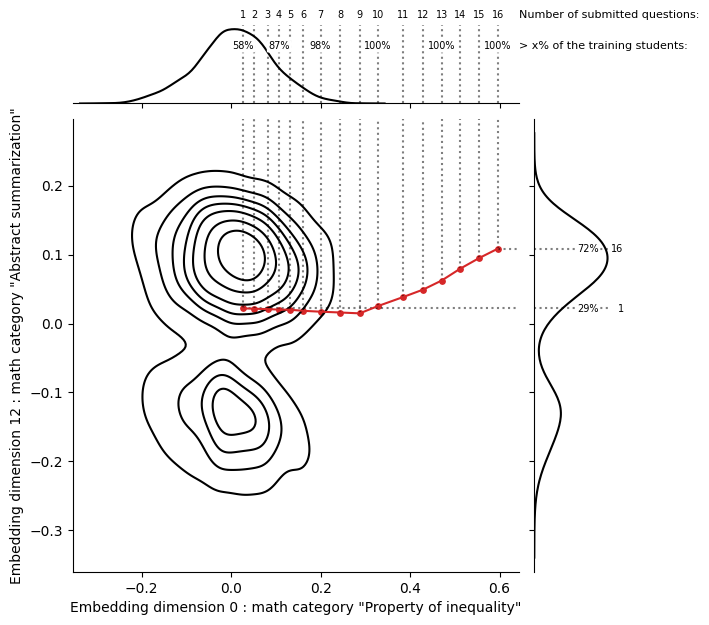

In [472]:
plot_embedding_distribution(0,12,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)

In [469]:
def plot_embedding_distribution_comp(i, j, t_np, test_emb, bins=50, xlim=None, ylim=None, test_data=None):
    x = t_np[:, i]
    y = t_np[:, j]

    # Main plot with marginal densities
    g = sns.jointplot(
        x=x, y=y,
        kind="kde",  # KDE for both joint and marginals
        fill=False,  # Contours only (no fill in joint)
        color="black",
        levels=8
    )

        # Set custom limits if provided
    if xlim is not None:
        g.ax_joint.set_xlim(xlim)
    if ylim is not None:
        g.ax_joint.set_ylim(ylim)

    test_users = torch.tensor(list(test_data.users_id))
    u_test = (-(test_emb[:,:,torch.tensor([i,j])][:,test_users,:]).std(axis=0).sum(dim=1)).argsort()
    users = test_users[u_test]
    
    v=test_data.df[test_data.df['user_id'].isin(users.numpy())]
    w_i=v[test_data.df['dimension_id']==i]
    x_i = w_i.groupby('user_id')['correct'].mean()
    
    w_j=v[test_data.df['dimension_id']==j]
    x_j = w_i.groupby('user_id')['correct'].mean()
    
    u0 = x_i.index[x_i.argmax()]
    u1 = x_i[x_i!=0].index[((x_i.mean()-x_i[x_i!=0]).abs()-(x_j.mean()-x_j).abs()).argmax()]
    u2 = x_i.index[(-x_i).argmax()]

    colors = ['tab:green','tab:blue', 'tab:red']

    px = t_np[:,i].mean().item()
    py = t_np[:,j].mean().item()

    perf_x=ecdf_percentiles(train_emb,i,px)
    perf_y=ecdf_percentiles(train_emb,j,py)

    ylim = g.ax_joint.get_ylim()    
    xlim = g.ax_joint.get_xlim()
    
    # Vertical dotted line (to top marginal axis)
    g.ax_joint.axvline(x=px, ymin=(py-ylim[0])/(ylim[1]-ylim[0]), linestyle=':', color='black', alpha=0.5)
    g.ax_marg_x.axvline(px, linestyle=':', color='black', alpha=0.5)
    # Add user index label above
    g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]+1.2, "Avg\nvalue", color='black', fontsize=7,
                     ha='center', va='top', rotation=0)
    # Pourcentage
    g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]-1, str(perf_x)+'%', color='black', fontsize=7,
                     ha='center', va='top', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))


    # Horizontal dotted line (to right marginal axis)
    g.ax_joint.axhline(py, xmin=(px-xlim[0])/(xlim[1]-xlim[0]), linestyle=':', color='black', alpha=0.5)
    g.ax_marg_y.axhline(py , linestyle=':', color='black', alpha=0.5)
    # Add user index label above
    g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]+0.2, py, "Avg\nvalue", color='black', fontsize=7,
                 ha='left', va='center', rotation=0)
     # pourcentage :
    g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]-1, py, str(perf_y)+'%', color='black', fontsize=7,
                     ha='right', va='center', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))

    

    for u_i, u in enumerate([u0,u1,u2]) : 

        g.ax_joint.scatter(test_emb[:,u,i],test_emb[:,u,j], s=15, color=colors[u_i%3])  
        g.ax_joint.plot(test_emb[:,u,i],test_emb[:,u,j], color=colors[u_i%3])  
        
        for idx in range(16):
            px = float(test_emb[idx, u, i])
            py = float(test_emb[idx, u, j])
    
            perf_x=ecdf_percentiles(train_emb,i,px)
            perf_y=ecdf_percentiles(train_emb,j,py)

            if idx==15:
                
                # Vertical dotted line (to top marginal axis)
                g.ax_joint.axvline(x=px, ymin=(py-ylim[0])/(ylim[1]-ylim[0]), linestyle=':', color=colors[u_i%3], alpha=0.5)
                g.ax_marg_x.axvline(px, linestyle=':', color=colors[u_i%3], alpha=0.5)
                # Add user index label above
                g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]+1.0, str(idx+1), color=colors[u_i%3], fontsize=7,
                                 ha='center', va='top', rotation=0)
                # Pourcentage
                g.ax_marg_x.text(px, g.ax_marg_x.get_ylim()[1]-1, str(perf_x)+'%', color=colors[u_i%3], fontsize=7,
                                 ha='center', va='top', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))


                # Horizontal dotted line (to right marginal axis)
                g.ax_joint.axhline(py, xmin=(px-xlim[0])/(xlim[1]-xlim[0]) ,linestyle=':', color=colors[u_i%3], alpha=0.5)
                g.ax_marg_y.axhline(py, linestyle=':', color=colors[u_i%3], alpha=0.5)
                g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]+1.0, py, str(idx+1), color=colors[u_i%3], fontsize=7,
                             ha='right', va='center', rotation=0)
                 # pourcentage :
                g.ax_marg_y.text(g.ax_marg_y.get_xlim()[1]-1, py, str(perf_y)+'%', color=colors[u_i%3], fontsize=7,
                                 ha='right', va='center', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))

                # Grades : 
                g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
                g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)

                print(f"Student {u} : Category {i}: {g_i}/100, Category {j}: {g_j}/100")

    g.ax_marg_x.text(g.ax_marg_x.get_xlim()[1], g.ax_marg_x.get_ylim()[1]+1.0, "Number of submitted questions", color='black', fontsize=8,
                             ha='left', va='top', rotation=0)
    g.ax_marg_x.text(g.ax_marg_x.get_xlim()[1], g.ax_marg_x.get_ylim()[1]-1, "> x% of the training students:", color='black', fontsize=8,
                                 ha='left', va='top', rotation=0, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15'))
    
    cat_i = skills[i+1]
    cat_j = skills[j+1]
    g.set_axis_labels(f'Embedding dimension {i} : math category "{cat_i}"', f'Embedding dimension {j} : math category "{cat_j}"')

    plt.tight_layout()
    plt.savefig("../data/students_comp.png", dpi=300, bbox_inches="tight")
    plt.show()
    

/tmp/ipykernel_89109/2585599192.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/2585599192.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/2585599192.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/2585599192.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/2585599192.py:104: UserWarning: Boolean Series key will be rein

Student 23 : Category 14: 100/100, Category 15: 50/100
Student 2 : Category 14: 50/100, Category 15: 0/100
Student 4 : Category 14: 0/100, Category 15: 50/100


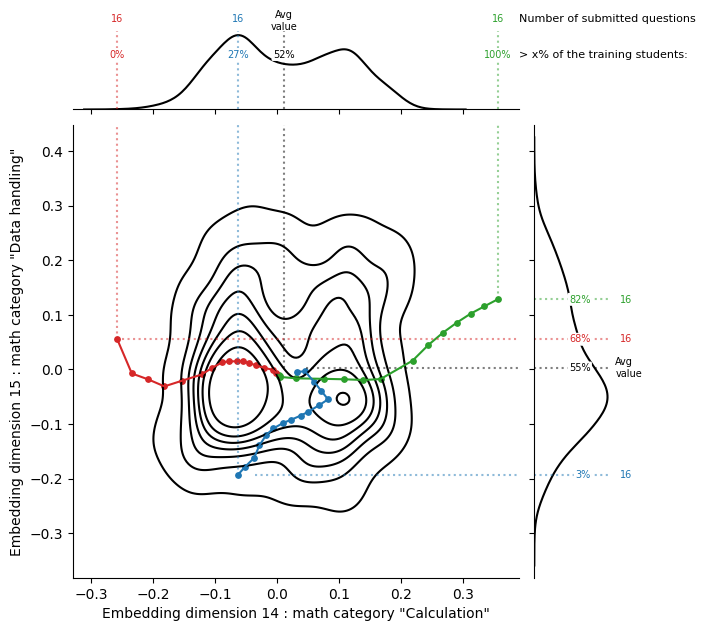

In [470]:
plot_embedding_distribution_comp(14,15,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)

/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed

Student 549 : Category 4: 100/100, Category 5: 66/100
Student 2 : Category 4: 50/100, Category 5: 33/100
Student 29 : Category 4: 0/100, Category 5: 0/100


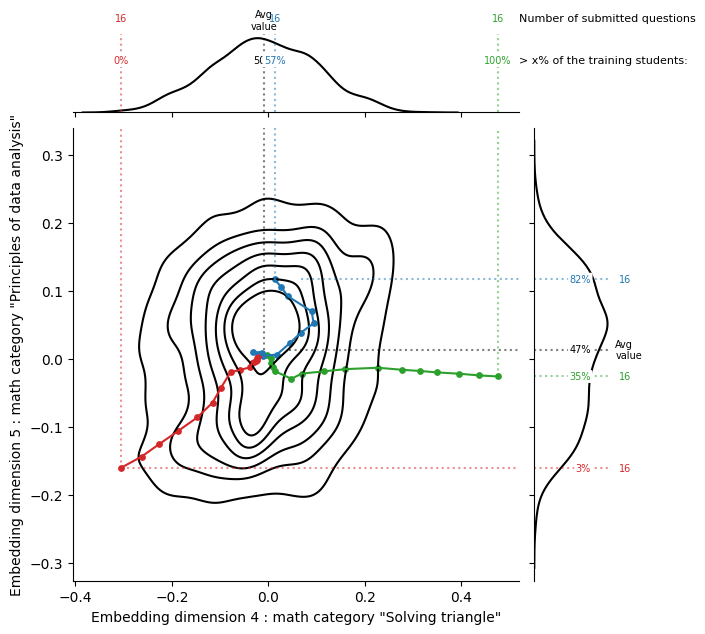

In [458]:
plot_embedding_distribution_comp(4,5,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)#, xlim=(-0.6,0.6), ylim=(-0.4,0.4))

/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed

Student 23 : Category 10: 100/100, Category 15: 50/100
Student 2 : Category 10: 66/100, Category 15: 0/100
Student 29 : Category 10: 0/100, Category 15: 0/100


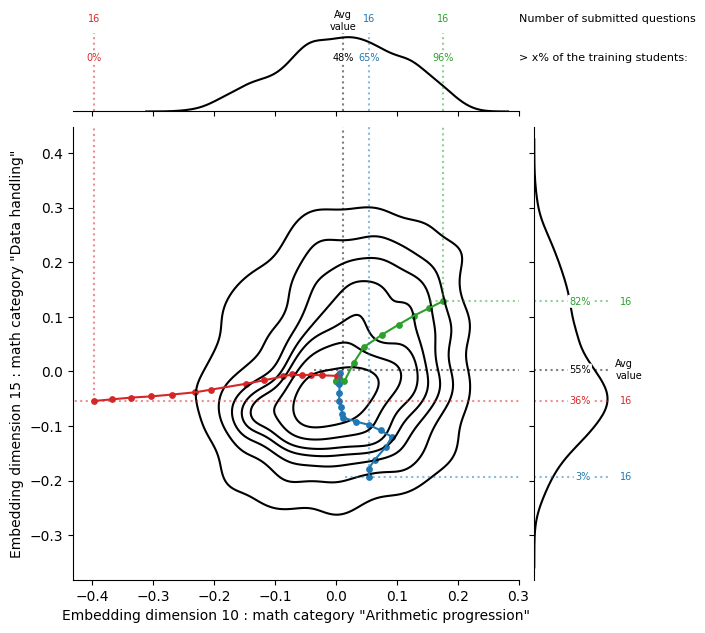

In [459]:
plot_embedding_distribution_comp(10,15,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)#, xlim=(-0.6,0.6), ylim=(-0.4,0.4))

/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed

Student 23 : Category 13: 100/100, Category 15: 50/100
Student 2 : Category 13: 50/100, Category 15: 0/100
Student 4 : Category 13: 0/100, Category 15: 50/100


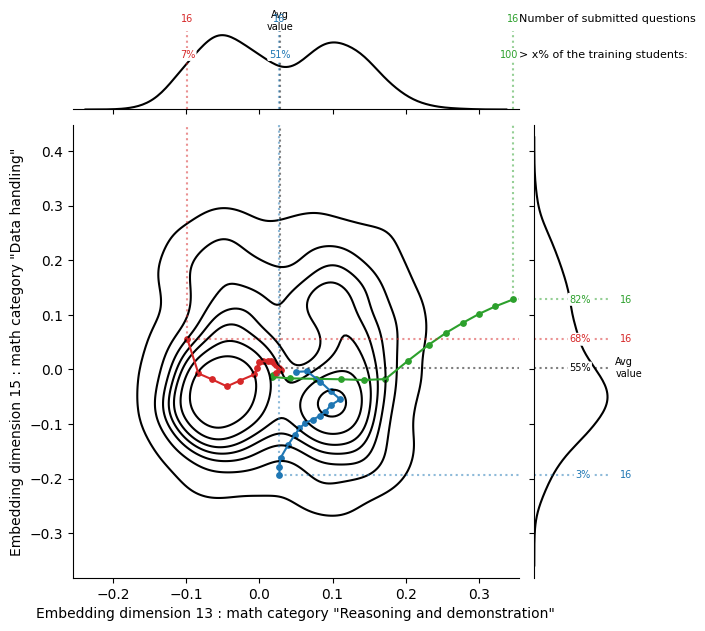

In [460]:
plot_embedding_distribution_comp(13,15,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)

/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_i = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==i]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_j = int((test_data.df[test_data.df['user_id']==u][test_data.df['dimension_id']==j]['correct'].mean()-1)*100)
/tmp/ipykernel_89109/184482044.py:104: UserWarning: Boolean Series key will be reindexed

Student 23 : Category 14: 100/100, Category 15: 50/100
Student 2 : Category 14: 50/100, Category 15: 0/100
Student 4 : Category 14: 0/100, Category 15: 50/100


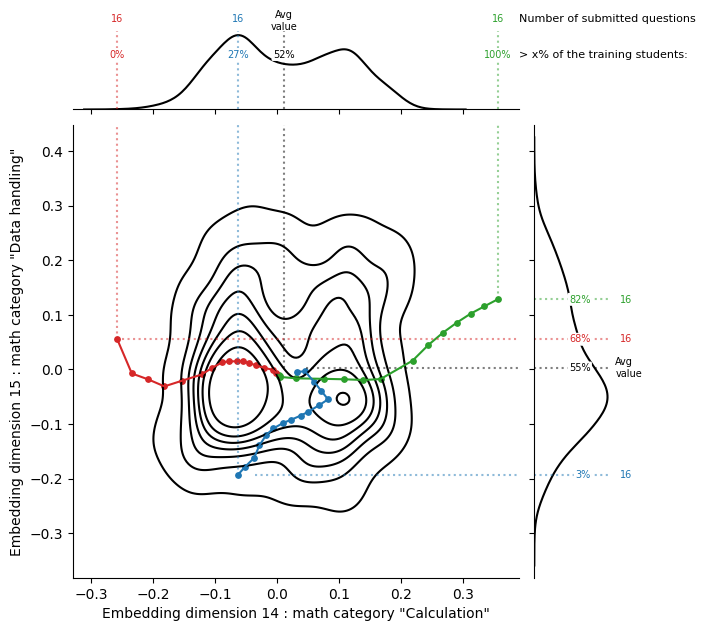

In [461]:
plot_embedding_distribution_comp(14,15,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


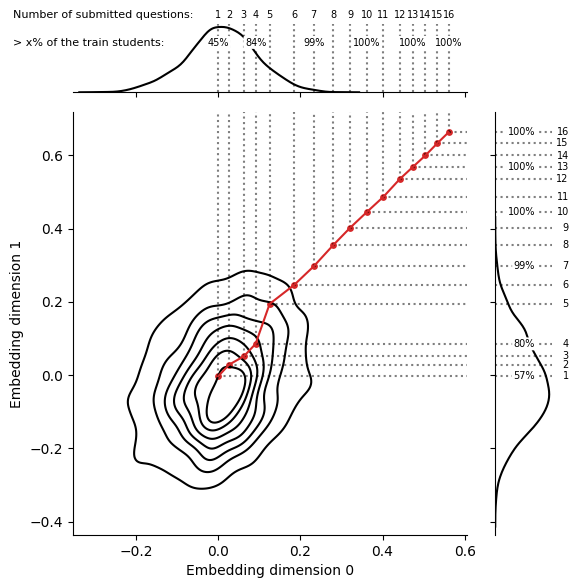

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


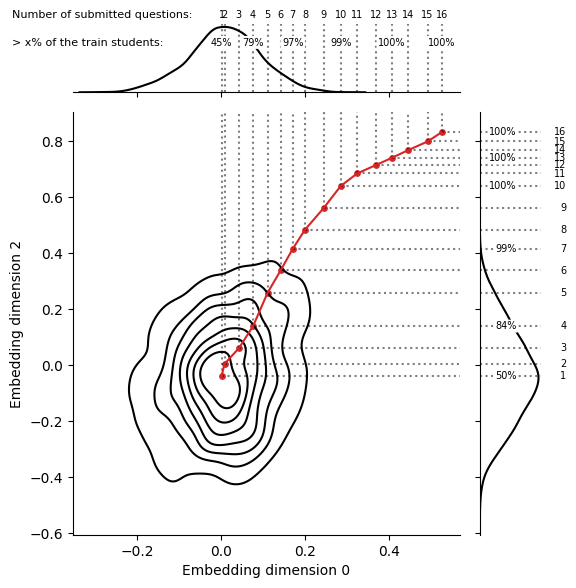

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


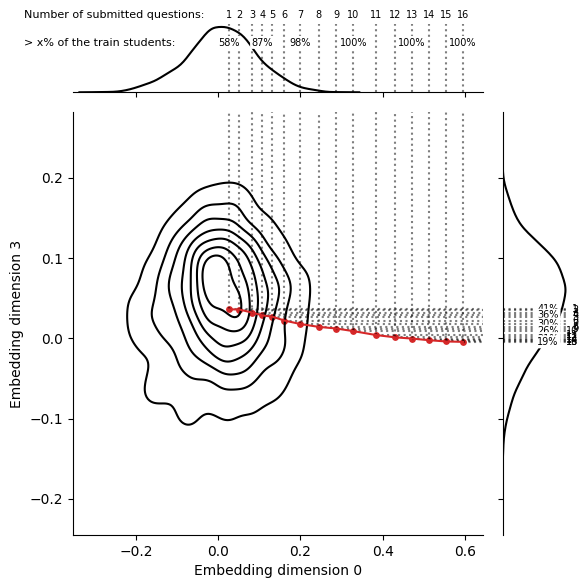

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


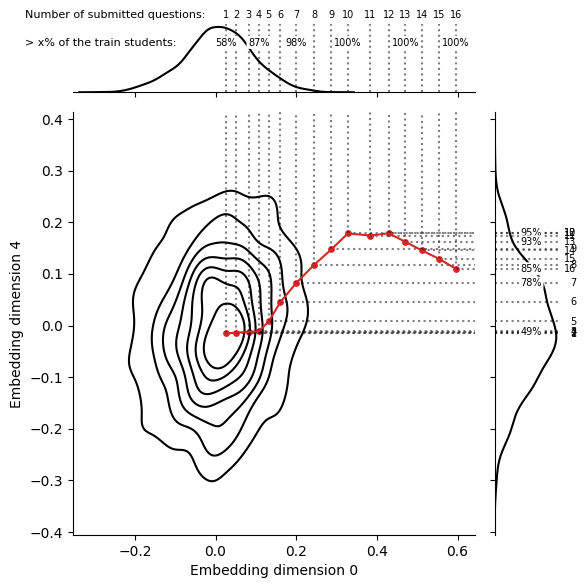

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


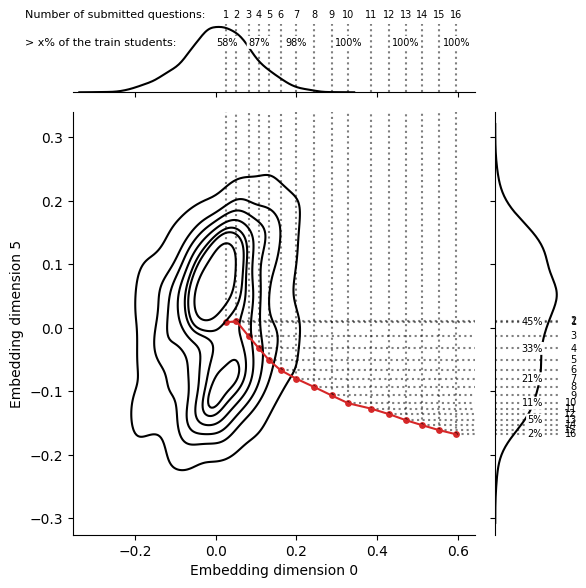

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


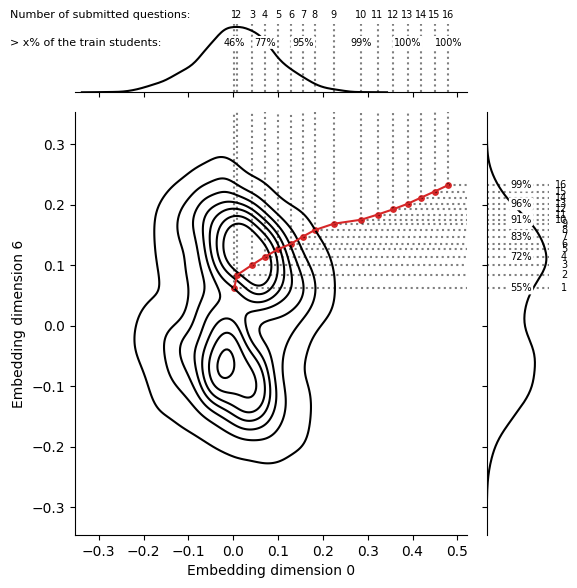

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


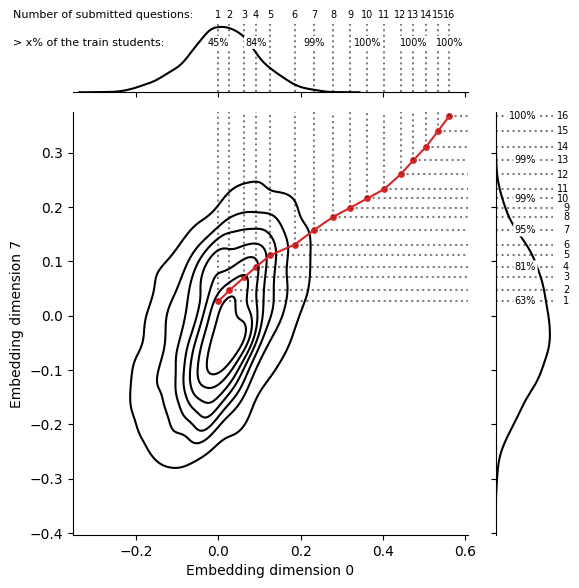

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


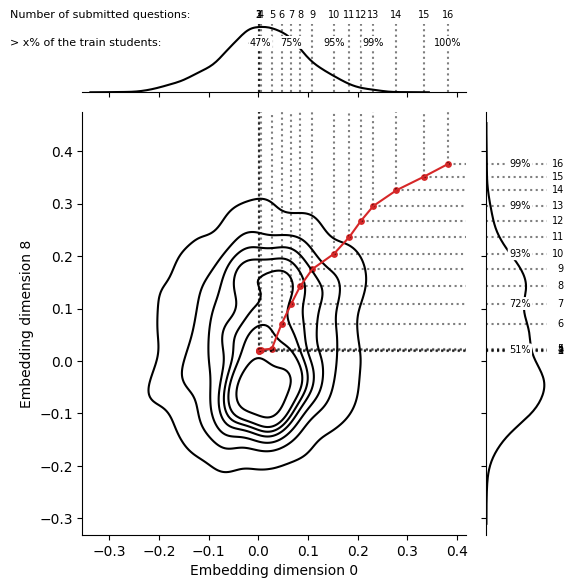

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


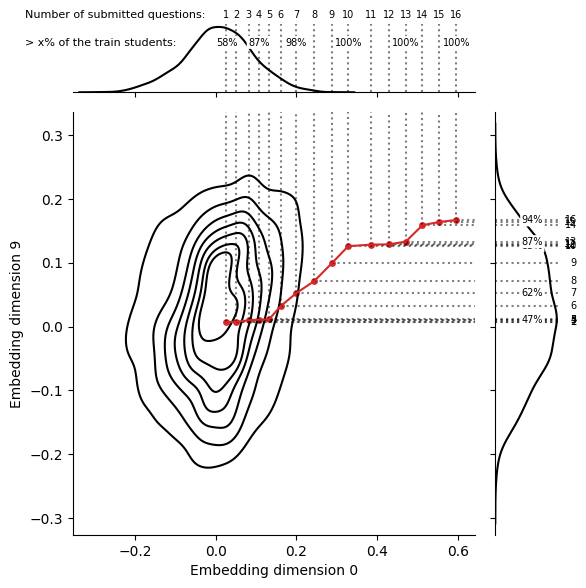

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


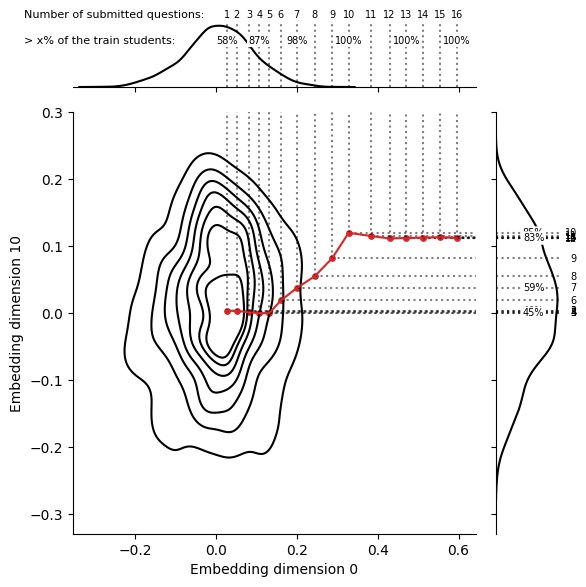

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


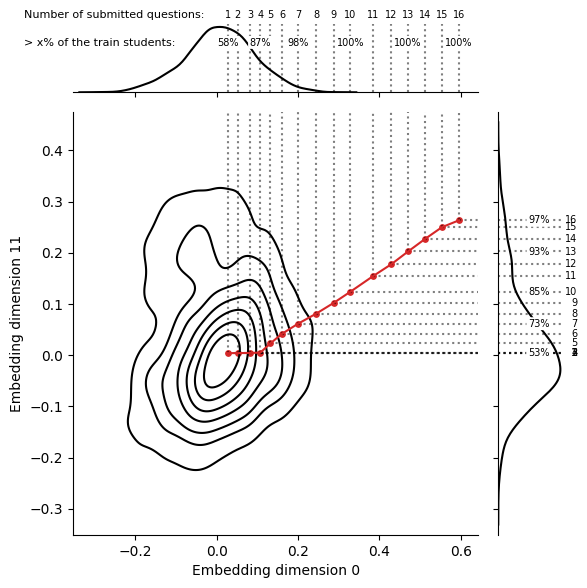

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


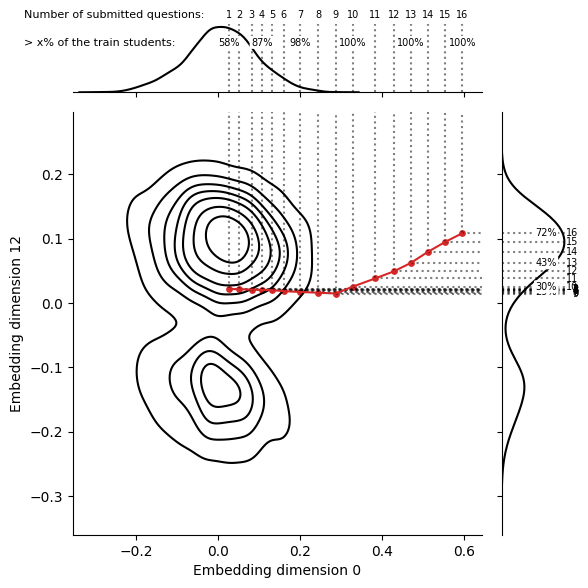

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


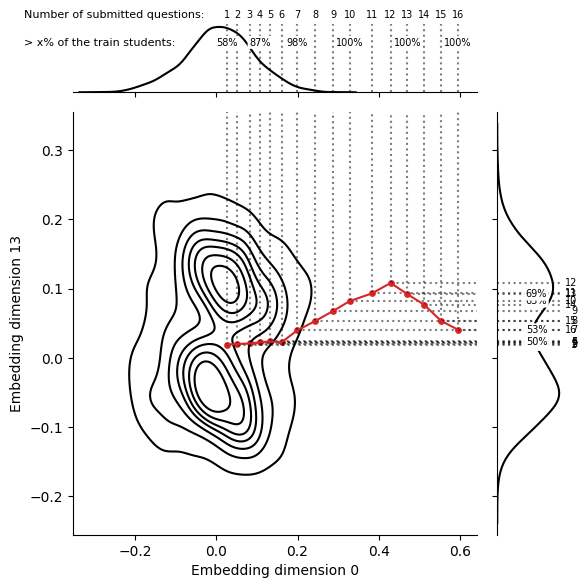

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


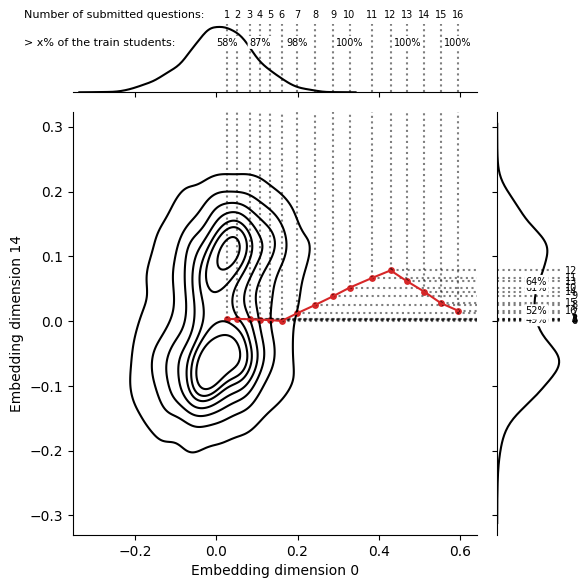

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


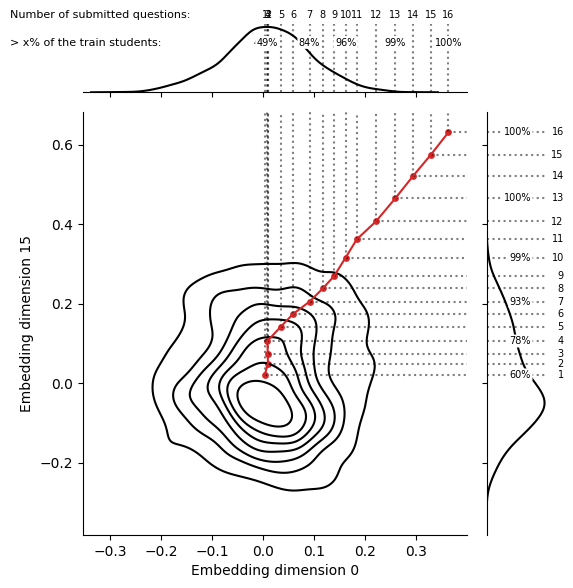

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


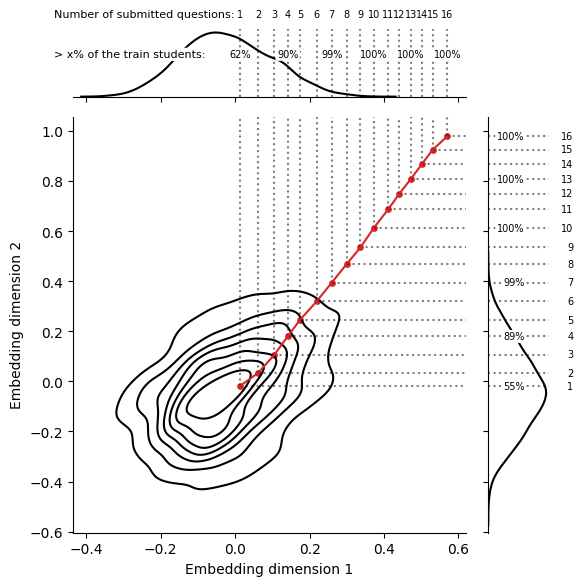

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


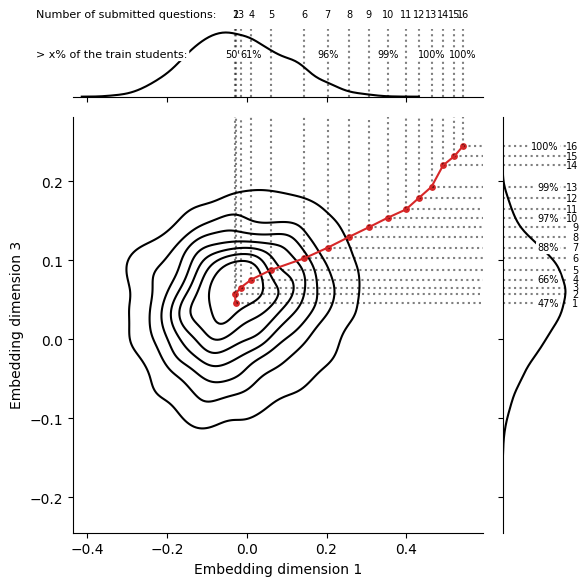

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


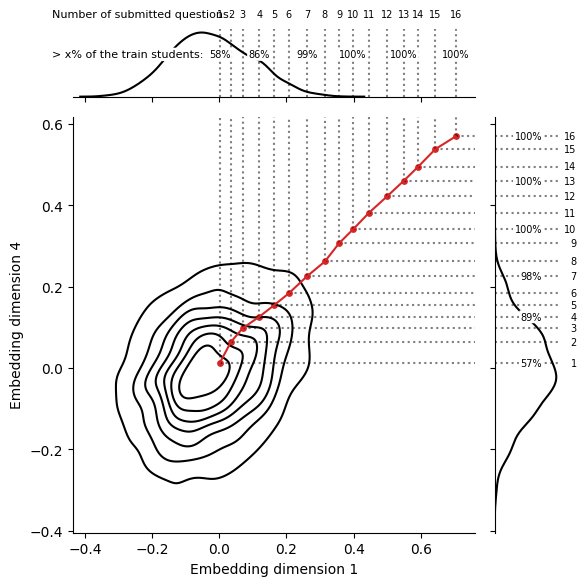

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


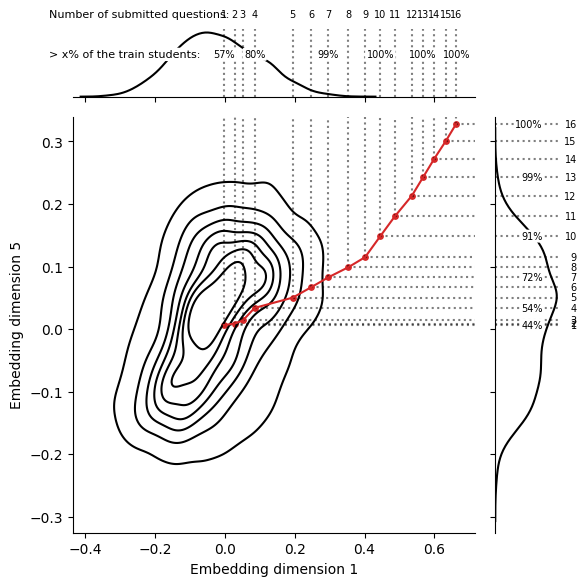

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


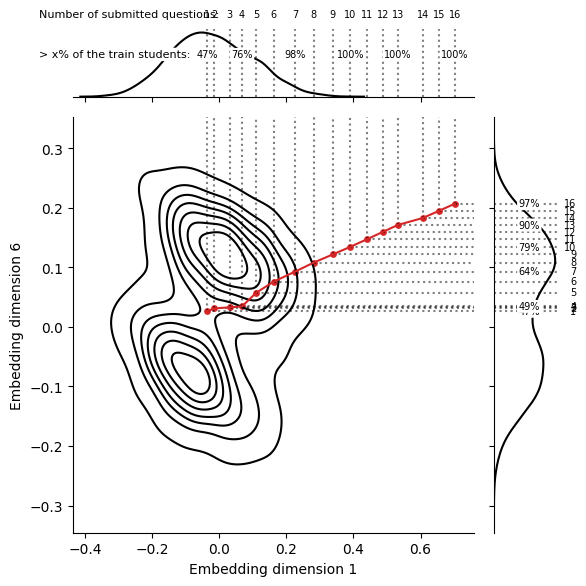

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


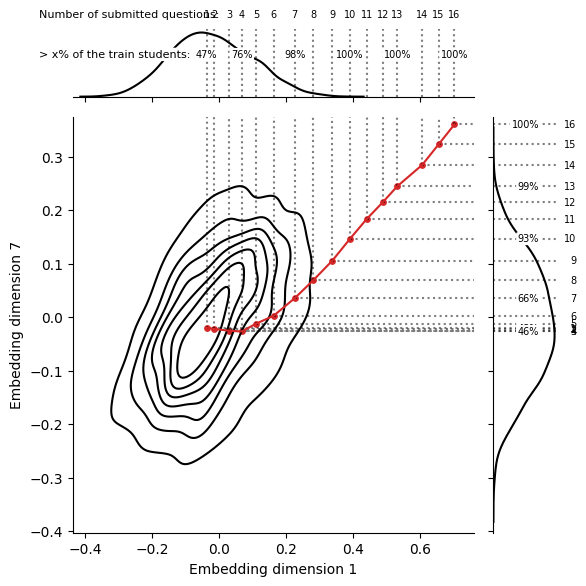

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


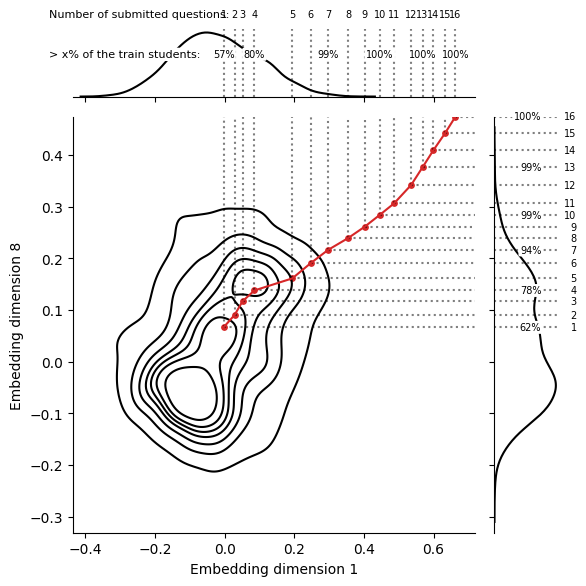

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


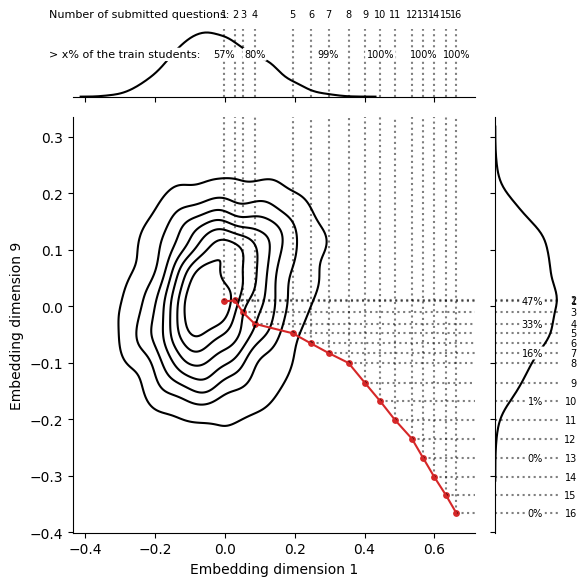

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


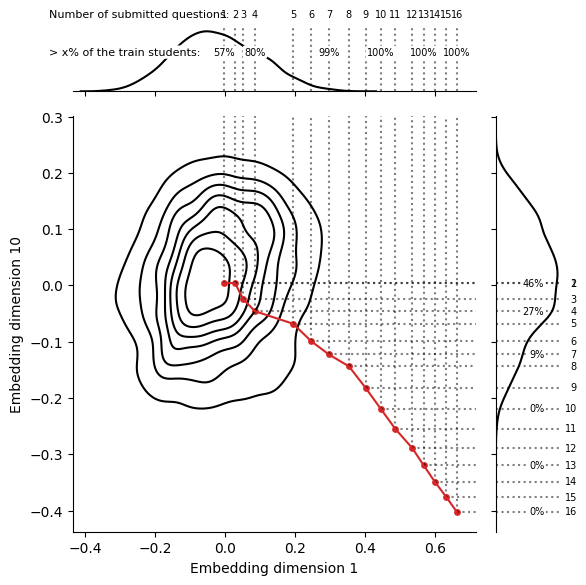

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


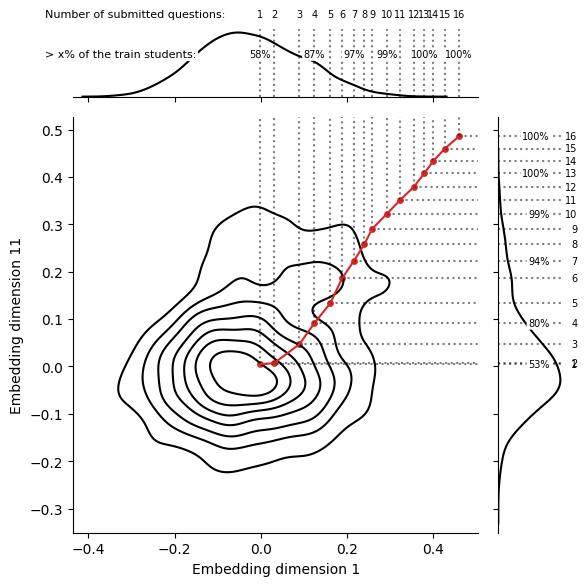

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


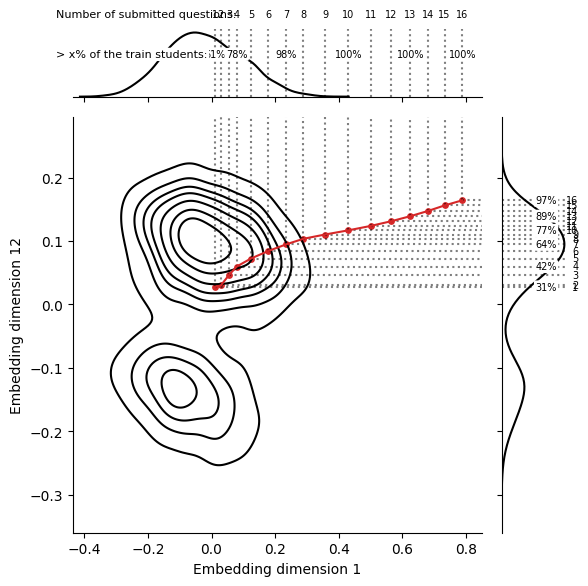

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


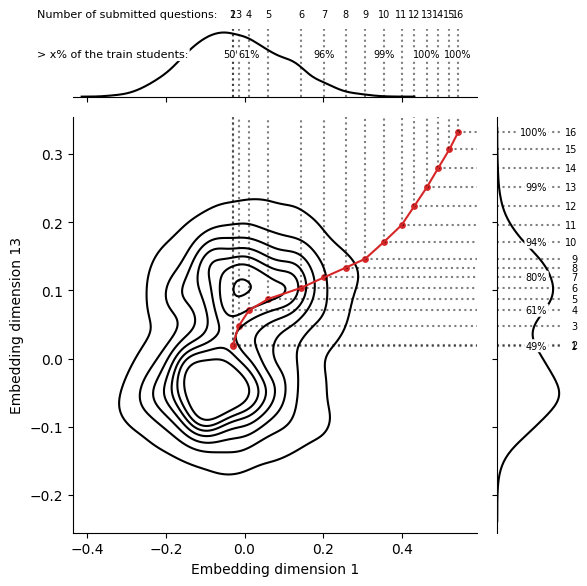

/tmp/ipykernel_89109/2402423095.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


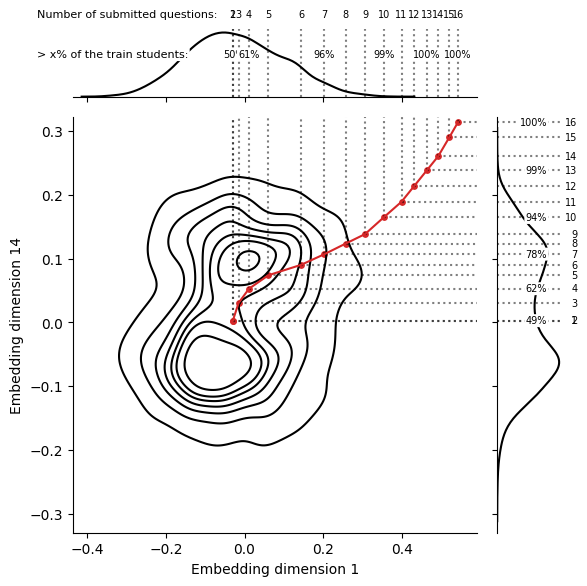

KeyboardInterrupt: 

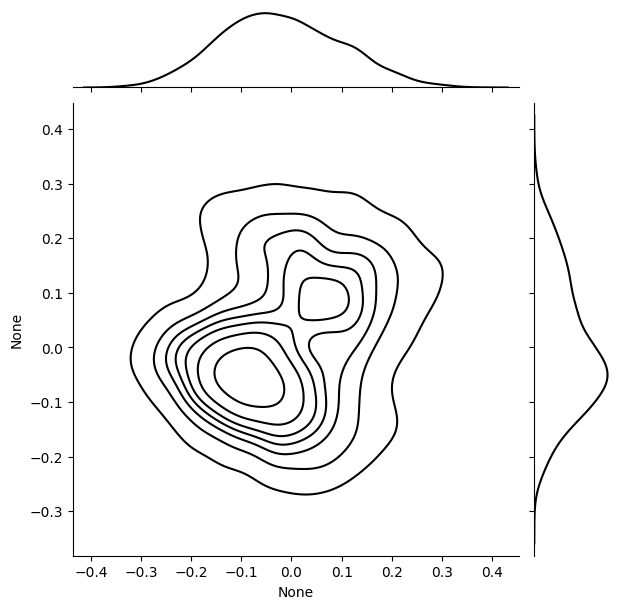

In [207]:
for i in range(16) : 
    for j in range(i,16):
        plot_embedding_distribution(0,j,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data)

In [198]:
test_users = torch.tensor(list(test_data.users_id))
u_test = (-(test_emb[:,:,torch.tensor([i,j])][:,test_users,:]).std(axis=0).sum(dim=1)).argsort()
users = test_users[u_test][:10]

v=test_data.df[test_data.df['user_id'].isin(users.numpy())]
w=v[test_data.df['dimension_id']==0]
x = w.groupby('user_id')['correct'].mean()
med = x.median()
u = x.index[(x-med).abs().argmin()]
u

/tmp/ipykernel_89109/1916064242.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


np.int64(1569)

In [196]:
(x-med).abs().argmin()

np.int64(2)

In [43]:
test_users = torch.tensor(list(test_data.users_id))
u_test = (-(test_emb[:,:,torch.tensor([i,j])][:,test_users,:]).std(axis=0).sum(dim=1)).argsort()
users = test_users[u_test][:10]

u = test_data.df[test_data.df['dimension_id']==0 and test_data.df['user_id']in users].groupby('user_id')['correct'].mean().argmax()
print(u)
g.ax_joint.plot(test_emb[:,u,i],test_emb[:,u,j])

In [64]:
i=0
j=1
test_users = torch.tensor(list(test_data.users_id))
u_test = (-(test_emb[:,:,torch.tensor([i,j])][:,test_users,:]).std(axis=0).sum(dim=1)).argsort()
users = test_users[u_test][:10]
print(users)

tensor([1156, 1569,  940, 2807, 3382, 2598, 3242, 3650, 3071, 3158])


In [77]:

print(u)

1156


/tmp/ipykernel_89109/3967173626.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w=v[test_data.df['dimension_id']==0]


In [78]:
test_emb[:,u,1]

tensor([-0.0033,  0.0283,  0.0512,  0.0851,  0.1942,  0.2465,  0.2967,  0.3540,
         0.4017,  0.4453,  0.4866,  0.5357,  0.5682,  0.5995,  0.6329,  0.6629])

In [71]:
u_test = test_emb[:,torch.tensor(list(test_data.users_id)),:].std(axis=0).argmax(dim=0)
torch.tensor(list(test_data.users_id))[u_test]

tensor([ 898,  268,    0, 1572,  800,  110,  955, 1561,   37, 1562, 1868, 1623,
        1792, 1657, 1664,  581, 1436, 2028,   63, 1441, 1817, 1355, 1246,  121,
         452, 1036, 1503, 1232, 1420, 1010, 1987,  898,   72, 1422, 1988,  686,
        1479,  746,  691,  967,   57,  280, 1153,  682, 1300,  636, 1225, 1623,
        1868,  898,  805, 1274,  814,  948,  900, 1562, 1692,  948, 1682,  207,
         207,  399, 1467,  900, 1469, 2035,  619,  619, 1732,  306, 1615,  405,
          83,  387,   62, 1295,  898, 1563, 1246, 1645,  279, 1232,  631, 1159,
          12,  901,  648,   12,   12,  898,  619,  880, 1023, 1603, 2040,  684,
         504,  341,  234,  746, 1987,  836, 2040,  898, 1433,  387, 1562, 1023,
        1023, 1023, 1023, 1771, 1023])

In [ ]:
test_emb.std(axis=0)[898]

In [54]:
test_emb[:,torch.tensor(list(test_data.users_id)),106]

tensor([[0.1726, 0.1722, 0.1708,  ..., 0.1696, 0.1701, 0.1679],
        [0.1739, 0.1749, 0.1724,  ..., 0.1703, 0.1728, 0.1679],
        [0.1739, 0.1770, 0.1736,  ..., 0.1748, 0.1729, 0.1684],
        ...,
        [0.1841, 0.1706, 0.2338,  ..., 0.2335, 0.1894, 0.2128],
        [0.1865, 0.1682, 0.2403,  ..., 0.2410, 0.1918, 0.2176],
        [0.1880, 0.1656, 0.2466,  ..., 0.2471, 0.1944, 0.2233]])

In [6]:
from liriscat import utils
from liriscat import dataset
from liriscat import CDM
import functools

def evaluation_state(func):
    """
    Temporary set the model state to "eval"
    """

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Extract 'self' from the first positional argument
        self = args[0] if args else None
        if self is None:
            raise ValueError("Decorator 'evaluation_state' requires to be used on instance methods.")

        # Store the previous state
        prev_state = getattr(self, 'state', None)

        try:
            # Set the state to 'eval' before method execution
            self.state = "eval"
            # Call the actual method
            self.CDM.model.eval()
            self.model.eval() # todo : putting in eval mode again
            with torch.no_grad(), torch.amp.autocast('cuda'):
                result = func(*args, **kwargs)
        finally:
            # Restore the previous state after method execution
            self.CDM.model.train()
            self.model.train() # todo : putting in eval mode again
            self.state = prev_state

        return result

    return wrapper
        
@evaluation_state
def evaluate_test_spec(self, test_dataset: dataset.EvalDataset,train_dataset: dataset.EvalDataset,valid_dataset: dataset.EvalDataset):
    """CATDataset
    Evaluate the model on the given data using the given metrics.
    """
    logging.debug("-- Evaluate test --")

    # Device cleanup
    torch.cuda.empty_cache()
    logging.info('train on {}'.format(self.config['device']))

    # Users embeddings initialization
    mvn = torch.distributions.MultivariateNormal(loc=self.CDM.model.prior_mean.squeeze(0), covariance_matrix=self.CDM.model.cov_matrix)
    learning_users_emb = nn.Parameter(mvn.sample((self.CDM.model.users_emb.weight.shape[0],)).requires_grad_(True))

    # Initialize testing config
    match self.config['meta_trainer']:
        case 'GAP':
            #mvn = torch.distributions.MultivariateNormal(loc=self.CDM.model.prior_mean, covariance_matrix=self.CDM.model.cov_matrix)
            #learning_users_emb = nn.Parameter(mvn.sample((test_dataset.n_users,)).squeeze(-2).requires_grad_(True))
            learning_users_emb = nn.Parameter(torch.tile(self.learning_users_emb, (self.metadata["num_user_id"], 1)).to(self.config['device']).requires_grad_(True))
        case 'BETA-CD':
            lambda_mean = nn.Parameter(torch.tile(self.user_mean, (self.metadata["num_user_id"], 1)).requires_grad_(True))
            lambda_std = nn.Parameter(torch.tile(self.user_log_std, (self.metadata["num_user_id"], 1)).requires_grad_(True))
            learning_users_emb = [lambda_mean, lambda_std]
        case 'MAML':
            learning_users_emb = nn.Parameter(torch.tile(self.learning_users_emb, (self.metadata["num_user_id"], 1)).to(self.config['device']).requires_grad_(True))
        case 'Approx_GAP':
            self.user_params_optimizer = torch.optim.Adam(
                [learning_users_emb],
                lr=self.config['inner_user_lr']
            )
        case 'Adam':
            self.user_params_optimizer = torch.optim.Adam(
                [learning_users_emb],
                lr=self.config['inner_user_lr']
            )
        case 'none':
            pass
        case _:
            raise ValueError(f"Unknown meta trainer: {self.config['meta_trainer']}")


    # Updating CDM to test dataset
    self.CDM.init_test(test_dataset)

    # Dataloaders preperation
    test_dataset.split_query_meta(self.config['seed'])
    test_query_env = QueryEnv(test_dataset, self.config['valid_batch_size'])
    test_loader = data.DataLoader(test_dataset, collate_fn=dataset.UserCollate(test_query_env), batch_size=self.config['valid_batch_size'],
                                  shuffle=False, pin_memory=self.config['pin_memory'], num_workers=self.config['num_workers'])

    # Saving metric structures
    pred_list = {t : [] for t in range(self.config['n_query'])}
    label_list = {t : [] for t in range(self.config['n_query'])}
    nb_modalities_list = {t : [] for t in range(self.config['n_query'])}
    emb_tensor = torch.zeros(size = (self.config['n_query'],test_dataset.n_users, test_dataset.n_categories), device=self.device)

    # Test
    log_idx = 0
    for batch in test_loader:

        test_query_env.load_batch(batch)

        # Prepare the meta set
        meta_data = test_query_env.generate_meta()
        nb_modalities = test_dataset.nb_modalities[meta_data['questions_id']]

        for i_query in tqdm(range(self.config['n_query']), total=self.config['n_query'], disable=self.config['disable_tqdm']):

            # Select the action (question to submit)
            options = test_query_env.get_query_options(i_query)
            actions = self.select_action(options)
            test_query_env.update(actions, i_query)

            learning_users_emb = self.inner_loop(test_query_env.feed_sub(),learning_users_emb)

            if self.config['meta_trainer'] == 'BETA-CD':
                with torch.no_grad() :
                    preds = torch.zeros(size=(meta_data['users_id'].shape[0],), device=self.device)
                    q_params = learning_users_emb
                    for _ in range(self.num_sample):
                        users_emb = q_params[0] + torch.randn_like(q_params[0], device=q_params[0].device) * torch.exp(q_params[1])
                        preds += self.CDM.forward(users_id=meta_data['users_id'], items_id=meta_data['questions_id'], concepts_id=meta_data['categories_id'], users_emb=users_emb)
                    preds /= self.num_sample
            else:
                with torch.no_grad() :
                    preds = self.CDM.forward(users_id=meta_data['users_id'], items_id=meta_data['questions_id'], concepts_id=meta_data['categories_id'], users_emb=learning_users_emb)

            pred_list[i_query].append(preds)
            label_list[i_query].append(meta_data['labels'])
            nb_modalities_list[i_query].append(nb_modalities)

            if self.config['meta_trainer'] == 'BETA-CD':
                # Store the updated user embeddings
                emb_tensor[i_query, :, :] = q_params[0]
            else:
                emb_tensor[i_query, :, :] = learning_users_emb

        log_idx += test_query_env.current_batch_size

    return  emb_tensor 

In [10]:
model_state_dict = S.best_model_params['state_dict']
meta_params = S.best_model_params['meta_params'].requires_grad_()
meta_lambda = S.best_model_params['meta_lambda'].requires_grad_()
cross_cond = S.best_model_params['cross_cond'].requires_grad_()
learning_users_emb = S.best_model_params['learning_users_emb'].requires_grad_()
